# Convolutional variational autoencoder with PyMC3 and Keras

In this document, I will show how autoencoding variational Bayes (AEVB) works in PyMC3's automatic differentiation variational inference (ADVI). The example here is borrowed from [Keras example](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py), where convolutional variational autoencoder is applied to the MNIST dataset. The network architecture of the encoder and decoder are the same. However, PyMC3 allows us to define a probabilistic model, which combines the encoder and decoder, in the same way as other probabilistic models (e.g., generalized linear models), rather than directly implementing of Monte Carlo sampling and the loss function, as is done in the Keras example. Thus the framework of AEVB in PyMC3 can be extended to more complex models such as [latent dirichlet allocation](https://taku-y.github.io/notebook/20160928/lda-advi-ae.html). 

- Notebook Written by Taku Yoshioka (c) 2016

To use Keras with PyMC3, we need to choose [Theano](http://deeplearning.net/software/theano/) as the backend for Keras. 

In [ ]:
%autosave 0
%matplotlib inline
import sys, os
%env KERAS_BACKEND=theano
%env THEANO_FLAGS=device=cuda3,floatX=float32,optimizer=fast_run

from collections import OrderedDict
from keras.layers import InputLayer, BatchNormalization, Dense, Conv2D, Deconv2D, Activation, Flatten, Reshape
import numpy as np
import pymc3 as pm
from theano import shared, config, function, clone, pp
import theano.tensor as tt
import keras
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from keras import backend as K
K.set_image_dim_ordering('th')

In [2]:
import pymc3, theano
print(pymc3.__version__)
print(theano.__version__)
print(keras.__version__)

3.1
0.9.0
2.0.4


## Load images
MNIST dataset can be obtained by [scikit-learn API](http://scikit-learn.org/stable/datasets/) or from [Keras datasets](https://keras.io/datasets/). The dataset contains images of digits. 

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
data = pm.floatX(x_train.reshape(-1, 1, 28, 28))
data /= np.max(data)

## Use Keras
We define a utility function to get parameters from Keras models. Since we have set the backend to Theano, parameter objects are obtained as shared variables of Theano. 

In the code, 'updates' are expected to include update objects (dictionary of pairs of shared variables and update equation) of scaling parameters of batch normalization. While not using batch normalization in this example, if we want to use it, we need to pass these update objects as an argument of `theano.function()` inside the PyMC3 ADVI function. The current version of PyMC3 does not support it, it is easy to modify (I want to send PR in future). 

The learning phase below is used for Keras to known the learning phase, training or test. This information is important also for batch normalization. 

In [4]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

def get_params(model):
    """Get parameters and updates from Keras model
    """
    shared_in_updates = list()
    params = list()
    updates = dict()
    
    for l in model.layers:
        attrs = dir(l)
        # Updates
        if 'updates' in attrs:
            updates.update(l.updates)
            shared_in_updates += [e[0] for e in l.updates]
        
        # Shared variables
        for attr_str in attrs:
            attr = getattr(l, attr_str)
            if isinstance(attr, tt.compile.SharedVariable):
                if attr is not model.get_input_at(0):
                    params.append(attr)
    
    return list(set(params) - set(shared_in_updates)), updates

# This code is required when using BatchNormalization layer
keras.backend.theano_backend._LEARNING_PHASE = \
    shared(np.uint8(1), name='keras_learning_phase')

## Encoder and decoder

First, we define the convolutional neural network for encoder using the Keras API. This function returns a CNN model given the shared variable representing observations (images of digits), the dimension of latent space, and the parameters of the model architecture. 

In [8]:
def cnn_enc(xs, latent_dim, nb_filters=64, nb_conv=3, intermediate_dim=128):
    """Returns a CNN model of Keras.
    
    Parameters
    ----------
    xs : theano.TensorVariable
        Input tensor.
    latent_dim : int
        Dimension of latent vector.
    """
    input_layer = InputLayer(input_tensor=xs, 
                             batch_input_shape=xs.tag.test_value.shape)
    model = Sequential()
    model.add(input_layer)
    
    cp1 = {'padding': 'same', 'activation': 'relu'}
    cp2 = {'padding': 'same', 'activation': 'relu', 'strides': (2, 2)}
    cp3 = {'padding': 'same', 'activation': 'relu', 'strides': (1, 1)}
    cp4 = cp3
    
    model.add(Conv2D(1, (2, 2), **cp1))
    model.add(Conv2D(nb_filters, (2, 2), **cp2))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), **cp3))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), **cp4))
    model.add(Flatten())
    model.add(Dense(intermediate_dim, activation='relu'))
    model.add(Dense(2 * latent_dim))

    return model

Then we define a utility class for encoders. This class does not depend on the architecture of the encoder except for input shape (`tensor4` for images), so we can use this class for various encoding networks. 

In [9]:
class Encoder:
    """Encode observed images to variational parameters (mean/std of Gaussian).

    Parameters
    ----------
    xs : theano.tensor.sharedvar.TensorSharedVariable
        Placeholder of input images. 
    dim_hidden : int
        The number of hidden variables. 
    net : Function
        Returns 
    """
    def __init__(self, xs, dim_hidden, net):
        model = net(xs, dim_hidden)
        
        self.model = model
        self.xs = xs
        self.out = model.get_output_at(-1)
        self.means = self.out[:, :dim_hidden]
        self.rhos = self.out[:, dim_hidden:]
        self.params, self.updates = get_params(model)
        self.enc_func = None
        self.dim_hidden = dim_hidden
        
    def _get_enc_func(self):
        if self.enc_func is None:
            xs = tt.tensor4()
            means = clone(self.means, {self.xs: xs})
            rhos = clone(self.rhos, {self.xs: xs})
            self.enc_func = function([xs], [means, rhos])
            
        return self.enc_func
    
    def encode(self, xs):
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))
        
        enc_func = self._get_enc_func()
        means, _ = enc_func(xs)
        
        return means

    def draw_samples(self, xs, n_samples=1):
        """Draw samples of hidden variables based on variational parameters encoded.
        
        Parameters
        ----------
        xs : numpy.ndarray, shape=(n_images, 1, height, width)
            Images.
        """
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        enc_func = self._get_enc_func()
        means, rhos = enc_func(xs)
        means = np.repeat(means, n_samples, axis=0)
        rhos = np.repeat(rhos, n_samples, axis=0)
        ns = np.random.randn(len(xs) * n_samples, self.dim_hidden)
        zs = means + pm.distributions.dist_math.rho2sd(rhos) * ns
        
        return zs

In a similar way, we define the decoding network and a utility class for decoders. 

In [10]:
def cnn_dec(zs, nb_filters=64, nb_conv=3, output_shape=(1, 28, 28)):
    """Returns a CNN model of Keras.
    
    Parameters
    ----------
    zs : theano.tensor.var.TensorVariable
        Input tensor.
    """
    minibatch_size, dim_hidden = zs.tag.test_value.shape
    input_layer = InputLayer(input_tensor=zs, 
                             batch_input_shape=zs.tag.test_value.shape)
    model = Sequential()
    model.add(input_layer)
        
    model.add(Dense(dim_hidden, activation='relu'))
    model.add(Dense(nb_filters * 14 * 14, activation='relu'))
    
    cp1 = {'padding': 'same', 'activation': 'relu', 'strides': (1, 1)}
    cp2 = cp1
    cp3 = {'padding': 'valid', 'activation': 'relu', 'strides': (2, 2)}
    cp4 = {'padding': 'same',  'activation': 'sigmoid'}

    output_shape_ = (minibatch_size, nb_filters, 14, 14)
    model.add(Reshape(output_shape_[1:]))
    model.add(Deconv2D(nb_filters, (nb_conv, nb_conv), data_format='channels_first', **cp1))
    model.add(Deconv2D(nb_filters, (nb_conv, nb_conv), data_format='channels_first', **cp2))
    output_shape_ = (minibatch_size, nb_filters, 29, 29)
    model.add(Deconv2D(nb_filters, (2, 2), data_format='channels_first', **cp3))
    model.add(Conv2D(1, (2, 2), **cp4))

    return model

In [11]:
class Decoder:
    """Decode hidden variables to images.
    
    Parameters
    ----------
    zs : Theano tensor
        Hidden variables.
    """
    def __init__(self, zs, net):
        model = net(zs)
        self.model = model
        self.zs = zs
        self.out = model.get_output_at(-1)
        self.params, self.updates = get_params(model)
        self.dec_func = None
        
    def _get_dec_func(self):
        if self.dec_func is None:
            zs = tt.matrix()
            xs = clone(self.out, {self.zs: zs})
            self.dec_func = function([zs], xs)
            
        return self.dec_func
        
    def decode(self, zs):
        """Decode hidden variables to images. 
        
        An image consists of the mean parameters of the observation noise.
        
        Parameters
        ----------
        zs : numpy.ndarray, shape=(n_samples, dim_hidden)
            Hidden variables. 
        """    
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        return self._get_dec_func()(zs)

## Generative model
We can construct the generative model with the PyMC3 API and the functions and classes defined above. We set the size of mini-batches to 100 and the dimension of the latent space to 2 for visualization. 

In [12]:
# Constants
minibatch_size = 100
dim_hidden = 2

We require a placeholder for images, into which mini-batches of images will be placed during ADVI inference. It is also the input for the encoder. Below, `enc.model` is a Keras model of the encoder network and we can check the model architecture using the method `summary()`. 

In [13]:
# Placeholder of images
xs_t = tt.tensor4(name='xs_t')
xs_t.tag.test_value = np.zeros((minibatch_size, 1, 28, 28)).astype('float32')
# Encoder
enc = Encoder(xs_t, dim_hidden, net=cnn_enc)
enc.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (100, 1, 28, 28)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (100, 1, 28, 28)          5         
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 64, 14, 14)         320       
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 64, 14, 14)         36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (100, 64, 14, 14)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (100, 12544)              0         
_________________________________________________________________
dense_1 (Dense)              (100, 128)                1605760   
__________

The probabilistic model involves only two random variables; latent variable $\mathbf{z}$ and observation $\mathbf{x}$. We put a Normal prior on $\mathbf{z}$, decode the variational parameters of $q(\mathbf{z}|\mathbf{x})$ and define the likelihood of the observation $\mathbf{x}$. 

In [14]:
with pm.Model() as model:
    # Hidden variables
    zs = pm.Normal('zs', mu=0, sd=1, shape=(minibatch_size, dim_hidden), dtype='float32', total_size=len(data))

    # Decoder and its parameters
    dec = Decoder(zs, net=cnn_dec)
    
    # Observation model
    xs_ = pm.Normal('xs_', mu=dec.out, sd=0.1, observed=xs_t, dtype='float32', total_size=len(data))

In the generative model above, we do not know how the decoded variational parameters are passed to $q(\mathbf{z}|\mathbf{x})$. To do this, we will set the argument `local_RVs` in the ADVI function of PyMC3. 

In [15]:
local_RVs = OrderedDict({zs: dict(mu=enc.means, rho=enc.rhos)})

This argument is an `OrderedDict` whose keys are random variables to which the decoded variational parameters are set (`zs` in this model). Each value of the dictionary contains two Theano expressions representing variational mean (`enc.means`) and rhos (`enc.rhos`). A scaling constant (`len(data) / float(minibatch_size)`) is set automatically (as we specified it in the model saying what's the `total_size`) to compensate for the size of mini-batches of the corresponding log probability terms in the evidence lower bound (ELBO), the objective of the variational inference. 

The scaling constant for the observed random variables is set in the same way. 

We can also check the architecture of the decoding network, as we did for the encoding network. 

In [16]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (100, 2)                  0         
_________________________________________________________________
dense_3 (Dense)              (100, 2)                  6         
_________________________________________________________________
dense_4 (Dense)              (100, 12544)              37632     
_________________________________________________________________
reshape_1 (Reshape)          (100, 64, 14, 14)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (100, 64, 14, 14)         36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (100, 64, 14, 14)         36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (100, 64, 28, 28)         16448     
__________

## Inference

Let's use ADVI to fit the model. 

In [17]:
# In memory Minibatches for better speed
xs_t_minibatch = pm.Minibatch(data, minibatch_size)

with model:
    approx = pm.fit(
        15000,
        local_rv=local_RVs,
        more_obj_params=enc.params + dec.params, 
        obj_optimizer=pm.rmsprop(learning_rate=0.001),
        more_replacements={xs_t:xs_t_minibatch},
    )

Average Loss = 1.9145e+07: 100%|██████████| 15000/15000 [3:02:18<00:00,  1.28it/s]  
Finished [100%]: Average Loss = 1.9133e+07


## Results

We can plot the trace of the negative ELBO obtained during optimization, to verify convergence. 

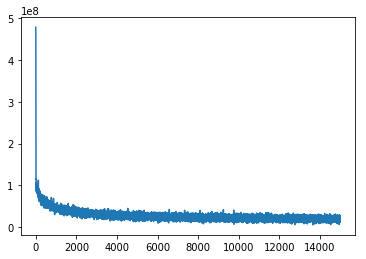

In [18]:
plt.plot(approx.hist);

Finally, we can plot the distribution of the images in the latent space. To do this, we make a 2-dimensional grid of points and feed them into the decoding network. The mean of $p(\mathbf{x}|\mathbf{z})$ is the image corresponding to the samples on the grid. 

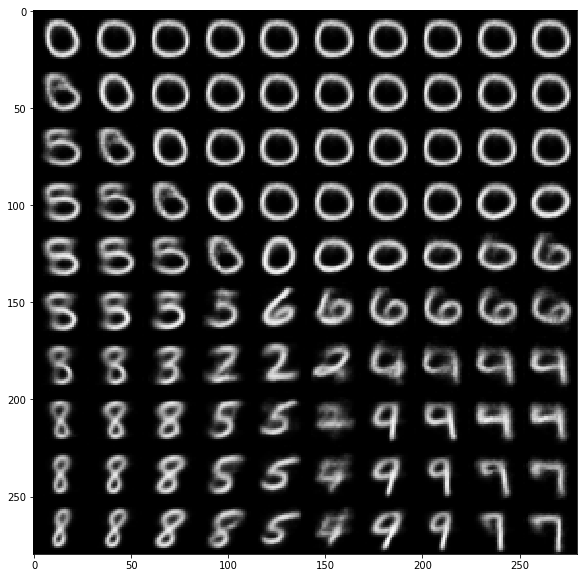

In [19]:
nn = 10
zs = np.array([(z1, z2) 
               for z1 in np.linspace(-2, 2, nn) 
               for z2 in np.linspace(-2, 2, nn)]).astype('float32')
xs = dec.decode(zs)[:, 0, :, :]
xs = np.bmat([[xs[i + j * nn] for i in range(nn)] for j in range(nn)])
matplotlib.rc('axes', **{'grid': False})
plt.figure(figsize=(10, 10))
plt.imshow(xs, interpolation='none', cmap='gray')
plt.show()